<h1><font color=darkred size=6><center> $\fbox{Classification Multimodale - Rakuten}$ </center></h1>
<font color=dimgrey size=3><center> $Bryan, \space Rizlène, \space Romain\space et \space Steeve$ </center></h1>

# Table des matières

## [Importation des librairies](#Imp)

## [Preprocessing](#Preprocess)

[1. Redimensionnement](#Redim)

[2. Normalisation](#Norm)

[3. Rotation](#Rotation)

[4. Retournement](#Retournement)

[5. Découpage (Cropping)](#Decoup)

[6. Ajout de bruit](#Bruit)

## [Bibliographies](#Bibli)

<h2><font size=6> Importation des librairies<a name="Imp"></a></h2>

In [65]:
import os
import csv
import warnings

from PIL import Image, ImageFilter
from IPython.display import display
import numpy as np
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from torchvision import transforms, models
import cv2
import re
import time

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 500
pd.options.display.max_columns = None

<h2><font size=6> Preprocessing <a name="Preprocess"></a></h2>

In [66]:
# Chemin vers le dossier contenant les images
dossier_images = "/Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/images/image_train"
doublons = ["1190251689", "1120457097"]
list_img_id = ["1169935358", "1308192555", "1313553701", "1308179167",
               "1046140130", "1323725983", "1188833125", "919752936",
               "1188538863", "718096430", "1313687465", "1120592010"]

# Liste des fichiers dans le dossier
fichiers_images = os.listdir(dossier_images)

# Filtrer pour ne garder que les fichiers d'images (par exemple, .jpg)
fichiers_images = [f for f in fichiers_images if f.endswith('.jpg')]


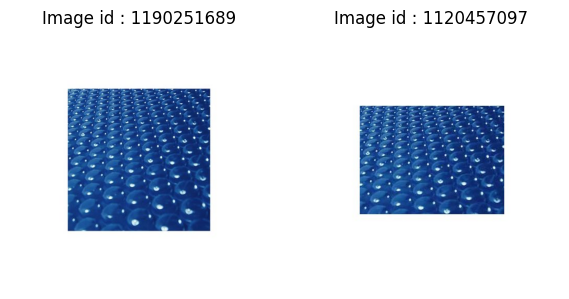

In [67]:
doublons_a_afficher = []

for i, fichier in enumerate(fichiers_images[:400]):
    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

    if image_id in doublons :
        doublons_a_afficher.append(fichier)

# Créer une figure pour afficher les images
plt.figure(figsize=(6, 3))

for i, fichier in enumerate(doublons_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

    # Ajouter une sous-figure
    plt.subplot(1, 2, i + 1)  # 2 lignes, 3 colonnes
    plt.imshow(image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image id : {image_id}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()


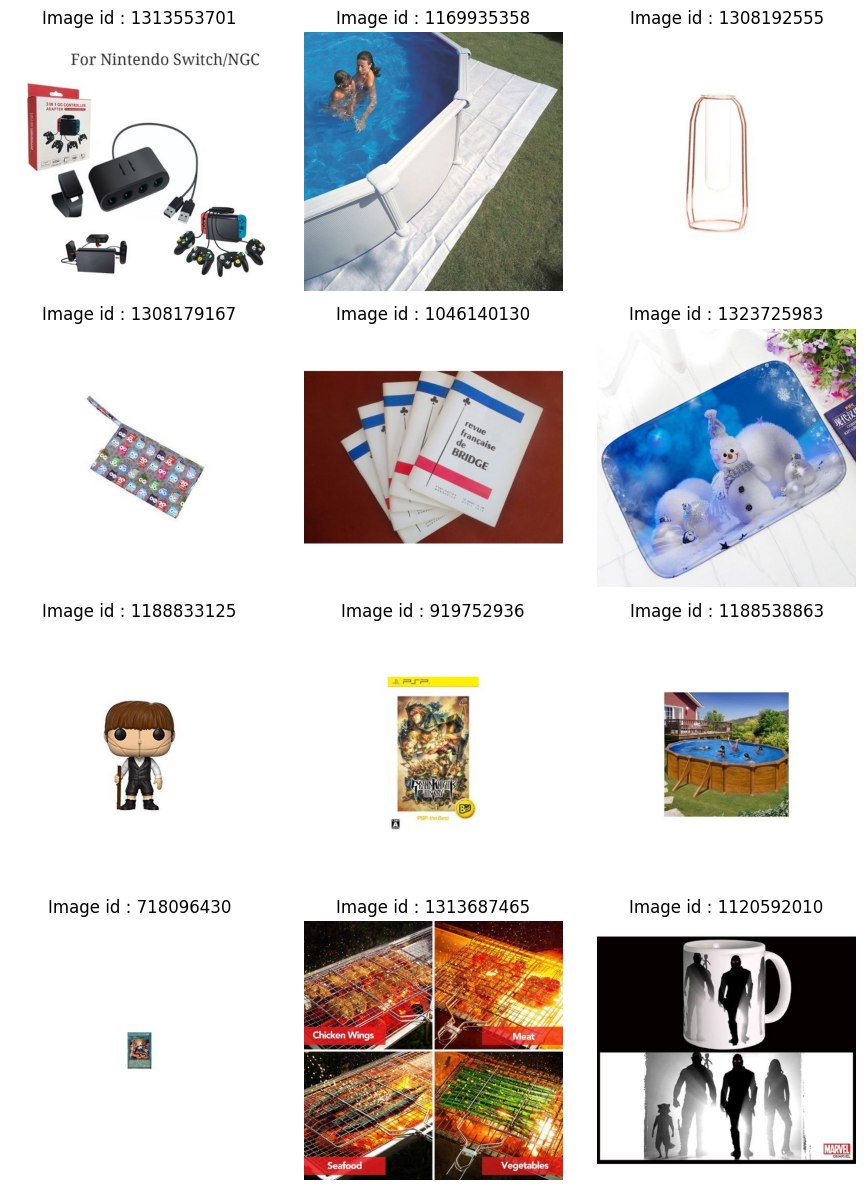

In [68]:
images_a_afficher = []

for i, fichier in enumerate(fichiers_images[:400]):
    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

    if image_id in list_img_id :
        images_a_afficher.append(fichier)

# Créer une figure pour afficher les images
plt.figure(figsize=(9, 12))

for i, fichier in enumerate(images_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

    # Ajouter une sous-figure
    plt.subplot(4, 3, i + 1)  # 2 lignes, 3 colonnes
    plt.imshow(image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image id : {image_id}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

<h3><font size=5> 1. Redimensionnement <a name="Redim"></a></h3>

In [69]:
def image_reduce_shape(img: np.ndarray, output_shape: tuple[int, int], seed_img: int) -> np.ndarray:
    """
    Reduce the dimensions of an image.

    Args:
        img (np.ndarray): The image to reduce.
        output_shape (tuple[int, int]): The new dimensions of the image.

    Returns:
        np.ndarray: The reduced image.
    """
    random.seed(seed_img)

    return np.array(cv2.resize(img, output_shape, interpolation=cv2.INTER_LINEAR))


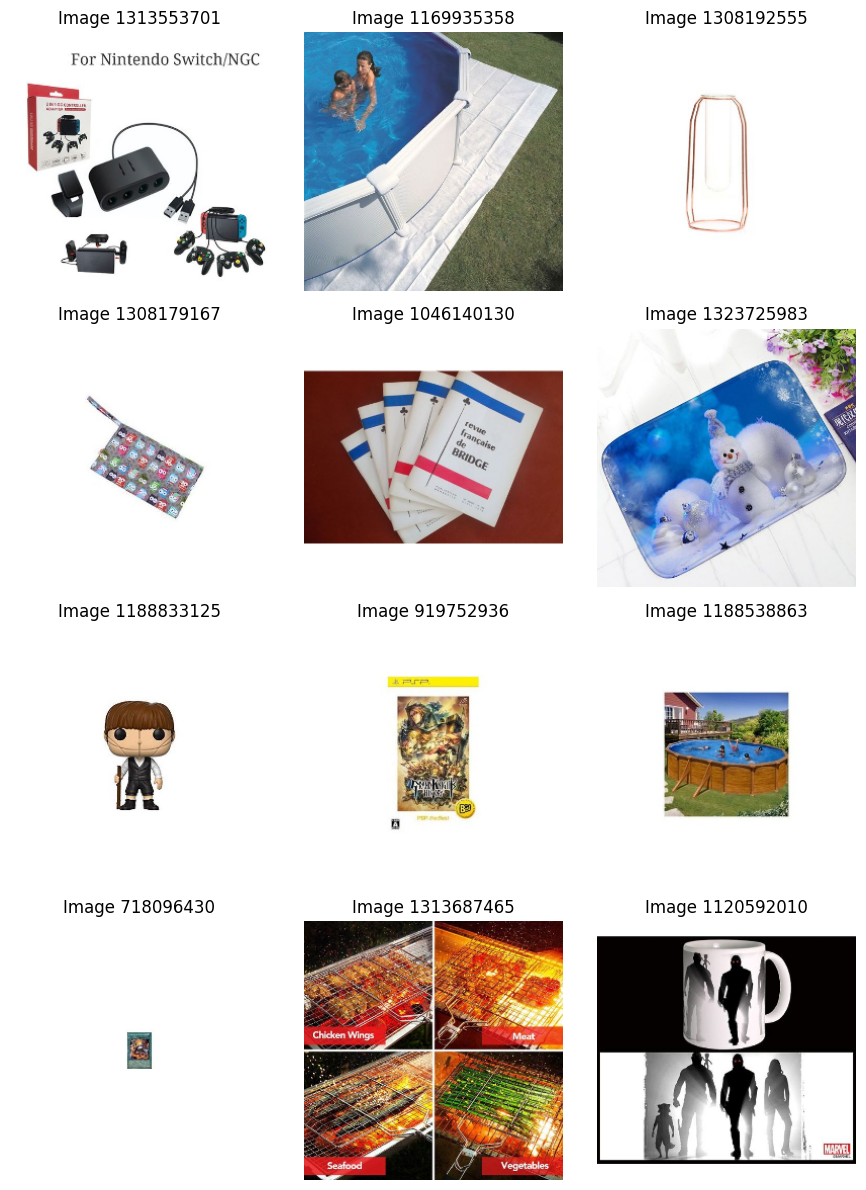

In [70]:
# Créer une figure pour afficher les images
plt.figure(figsize=(9, 12))

for i, fichier in enumerate(images_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)
    
    # Redimensionner l'image à 256x256 pixels
    resized_image = image_reduce_shape(image, (256, 256), seed_img=image_id)
    
    # Ajouter une sous-figure
    plt.subplot(4, 3, i + 1)  # 5 lignes, 3 colonnes
    plt.imshow(resized_image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image {image_id}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

<h3><font size=5> 2. Normalisation <a name="Norm"></a></h3>

In [71]:
def image_to_normalize(image: np.ndarray, mean: float, std: float, seed_img: int) -> np.ndarray:
    """
    Normalize an image by scaling pixel values to the range [0, 1] and then applying mean and standard deviation.

    Args:
        image (np.ndarray): The image to normalize.
        mean (float): The mean value for normalization.
        std (float): The standard deviation for normalization.

    Returns:
        np.ndarray: The normalized image.
    """
    random.seed(seed_img)

    image_array = np.array(image) / 255.0  # Normalize to the range [0, 1]
    return (image_array - mean) / std


In [72]:
for i, fichier in enumerate(images_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)
    
    # Normaliser l'image
    normalized_image = image_to_normalize(resized_image, mean=0.5, std=0.5, seed_img=image_id)


<h3><font size=5> 3. Rotation <a name="Rotation"></a></h3>

In [73]:
def image_to_rotate(img: np.ndarray, angle: float, seed_img: int) -> np.ndarray:
    """
    Rotate an image by a specified angle.

    Args:
        img (np.ndarray): The image to rotate.
        angle (float): The angle in degrees to rotate the image.

    Returns:
        np.ndarray: The rotated image.
    """
    random.seed(seed_img)

    if random.choice([0,1]) == 0:
        return np.array(img)

    height, width = img.shape[:2]
    M = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    return np.array(cv2.warpAffine(img, M, (width, height)))


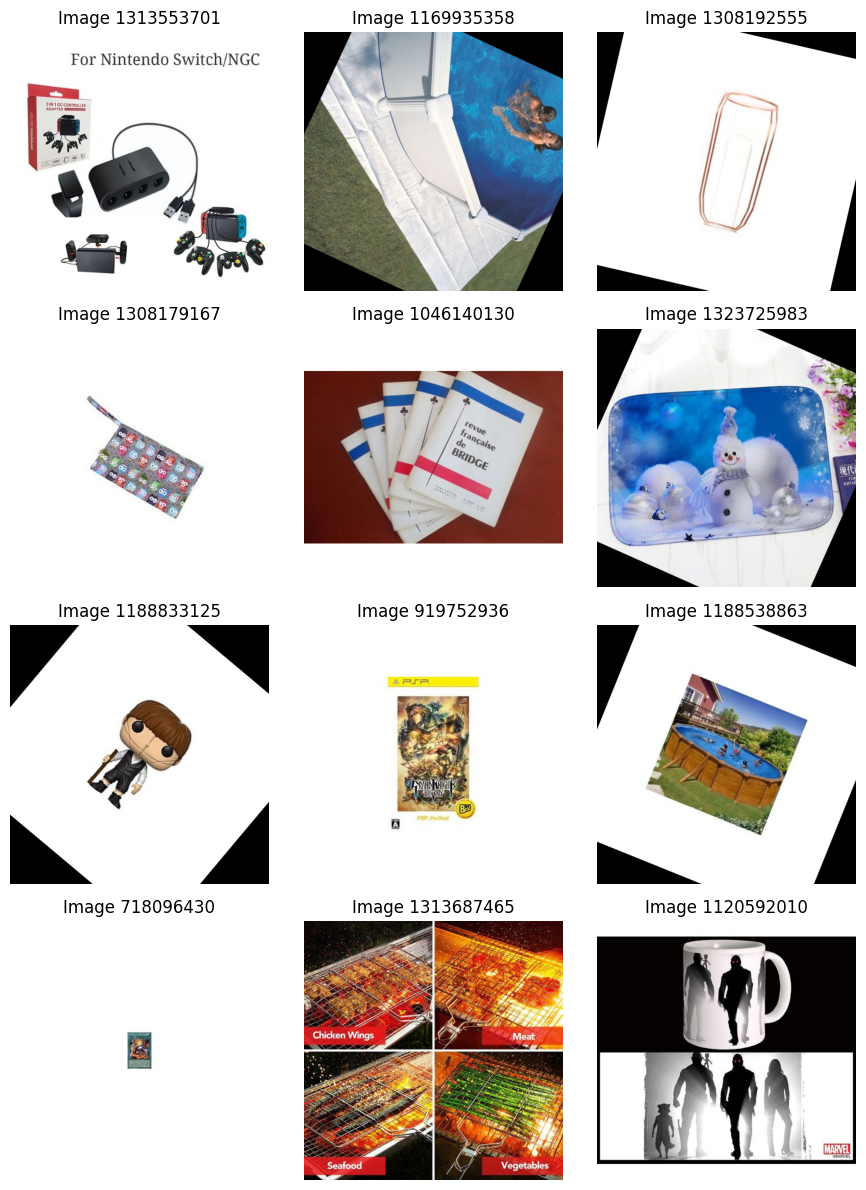

In [74]:
# Créer une figure pour afficher les images
plt.figure(figsize=(9, 12))

for i, fichier in enumerate(images_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)
    
    # Augmenter l'image
    rotate_image = image_to_rotate(image, random.randint(0, 360), seed_img=image_id)

    # Ajouter une sous-figure
    plt.subplot(4, 3, i + 1)  # 6 lignes, 4 colonnes
    plt.imshow(rotate_image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image {image_id}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

<h3><font size=5> 4. Retournement <a name="Retournement"></a></h3>

In [75]:
def image_to_flip(img: np.ndarray, symmetry: int, seed_img: int) -> np.ndarray:
    """
    Flip an image along a specified axis.

    Args:
        img (np.ndarray): The image to flip.
        symmetry (int): The axis to flip the image. 
                        0 for vertical flip, 
                        1 for horizontal flip, 
                        -1 for both.

    Returns:
        np.ndarray: The flipped image.
    """
    random.seed(seed_img)

    if random.choice([0,1]) == 0:
        return np.array(img)

    return np.array(cv2.flip(img, symmetry))

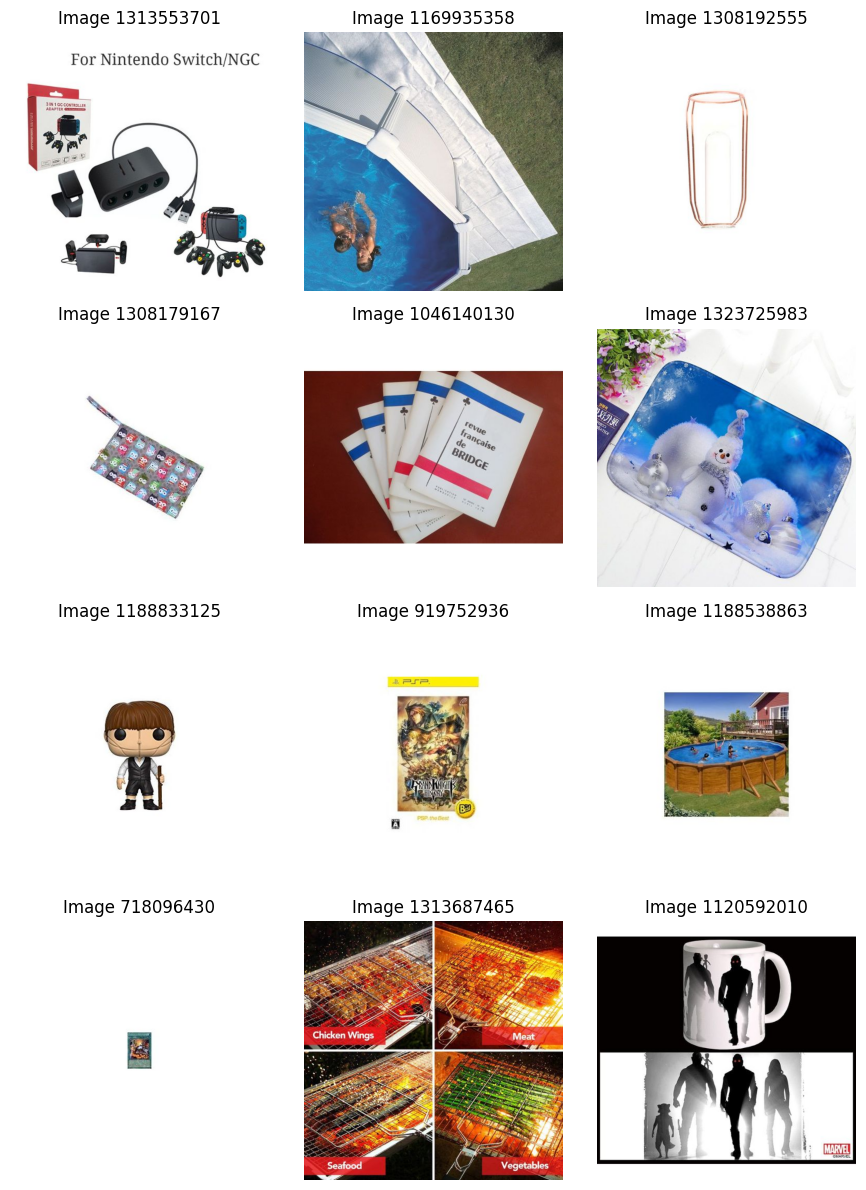

In [76]:
# Créer une figure pour afficher les images
plt.figure(figsize=(9, 12))

for i, fichier in enumerate(images_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)
    
    # Augmenter l'image
    flip_image = image_to_flip(image, random.randint(-1, 1), seed_img=image_id)
    
    # Ajouter une sous-figure
    plt.subplot(4, 3, i + 1)  # 6 lignes, 4 colonnes
    plt.imshow(flip_image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image {image_id}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

<h3><font size=5> 5. Découpage (Cropping) <a name="Decoup"></a></h3>

In [77]:
def image_to_crop(image: np.ndarray, x: int, width: int, y: int, height: int, seed_img: int) -> np.ndarray:
    """
    Crop an image to a specified region.

    Args:
        image (np.ndarray): The image to crop.
        x (int): The x-coordinate of the top-left corner of the crop area.
        y (int): The y-coordinate of the top-left corner of the crop area.
        width (int): The width of the crop area.
        height (int): The height of the crop area.

    Returns:
        np.ndarray: The cropped image.
    """
    random.seed(seed_img)

    #if random.choice([0,1]) == 0:
    #    return np.array(image)
    
    return np.array(image[y:y + height, x:x + width])


In [78]:
list_img_to_crop_id = ["1313553701", "1308192555", "1308179167", "1188833125",
                       "919752936", "1188538863", "718096430", "1313687465",
                       "1120592010"]
images_to_crop_a_afficher = []

for i, fichier in enumerate(images_a_afficher):
    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

    if image_id in list_img_to_crop_id:
        images_to_crop_a_afficher.append(fichier)


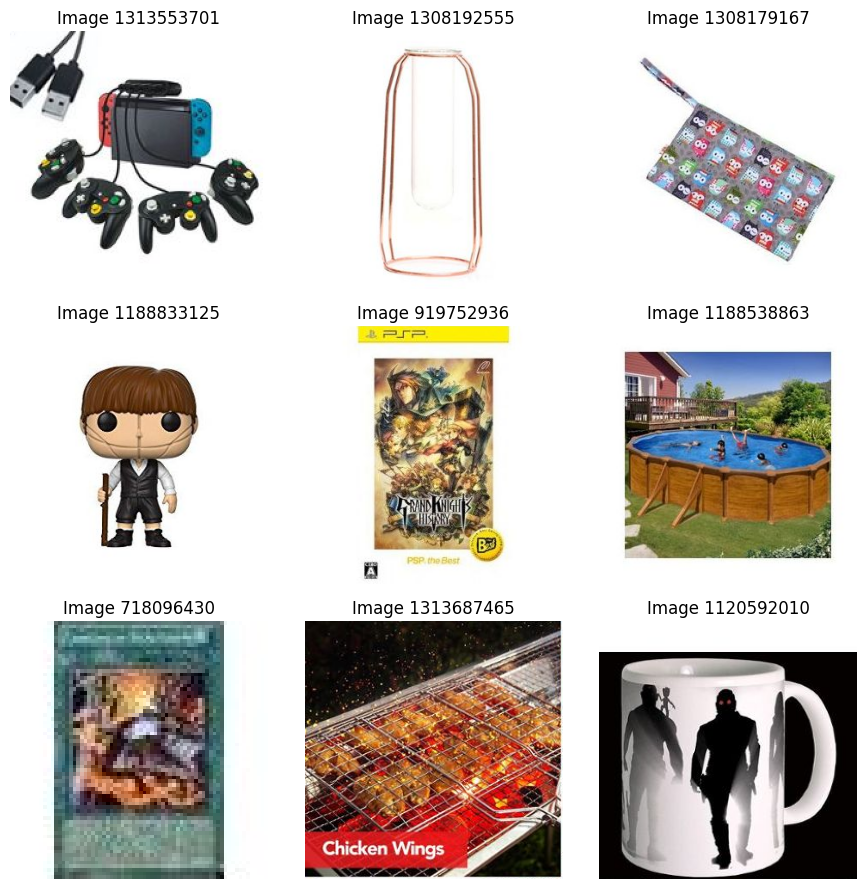

In [79]:
# Créer une figure pour afficher les images
plt.figure(figsize=(9, 9))

for i, fichier in enumerate(images_to_crop_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

    if image_id == "1313553701":
        cropped_image = image_to_crop(image, 300, 450, 300, 450, seed_img=image_id)
    elif image_id == "1308192555":
        cropped_image = image_to_crop(image, 85, 300, 100, 300, seed_img=image_id)
    elif image_id == "1308179167":
        cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
    elif image_id == "1188833125":
        cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
    elif image_id == "919752936":
        cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
    elif image_id == "1188538863":
        cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
    elif image_id == "718096430":
        cropped_image = image_to_crop(image, 215, 70, 215, 70, seed_img=image_id)
    elif image_id == "1313687465":
        cropped_image = image_to_crop(image, 0, 250, 0, 250, seed_img=image_id)
    elif image_id == "1120592010":
        cropped_image = image_to_crop(image, 145, 250, 0, 250, seed_img=image_id)
    else:
        cropped_image = image

    # Ajouter une sous-figure
    plt.subplot(3, 3, i + 1)  # 5 lignes, 5 colonnes
    plt.imshow(cropped_image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image {image_id}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

<h3><font size=5> 6. Ajout de bruit <a name="Bruit"></a></h3>

L'ajout de bruit peut rendre le modèle plus robuste en l'exposant à des données moins parfaites. Cela simule des conditions réelles où les images peuvent être bruitées ou de mauvaise qualité.

In [80]:
def image_with_gaussian_noise(image: np.ndarray, seed_img: int, noise_type: str = 'gaussian') -> np.ndarray:
    """
    Add Gaussian noise to an image.

    Args:
        image (np.ndarray): The input image to which noise will be added.
        noise_type (str): The type of noise to add. Currently, only 'gaussian' is supported.

    Returns:
        np.ndarray: The image with added noise.
    """
    random.seed(seed_img)

    if random.choice([0,1]) == 0 :
        return np.array(image)

    image_array = np.array(image)
    if noise_type == 'gaussian':
        numbers = [1, 4, 9, 25, 36, 49, 64, 81, 100]
        noise = np.random.normal(0, random.choice(numbers), image_array.shape)  # Generate Gaussian noise
        noisy_image = np.clip(image_array + noise, 0, 255)  # Ensure pixel values remain in [0, 255]
        return np.uint8(noisy_image)  # Convert back to uint8 format
    return np.array(image)


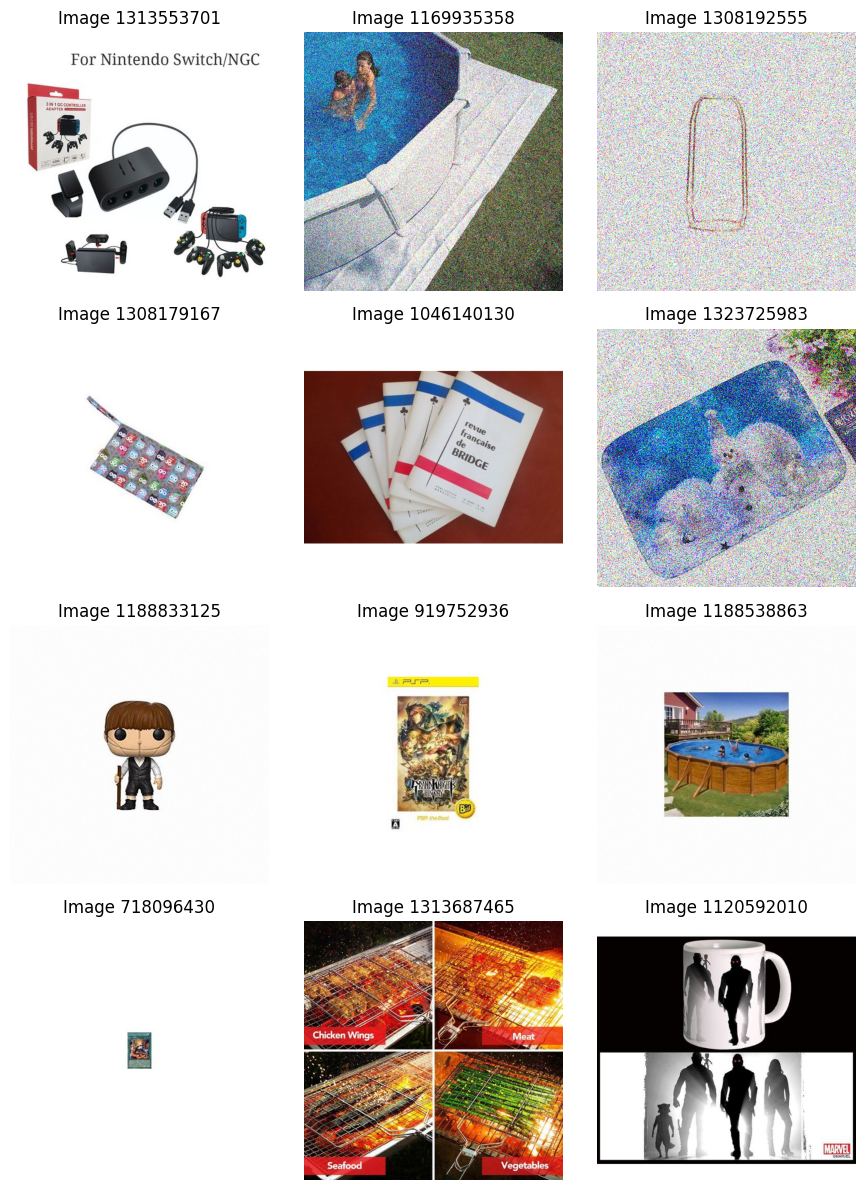

In [81]:
# Créer une figure pour afficher les images
plt.figure(figsize=(9, 12))

for i, fichier in enumerate(images_a_afficher):
    # Ouvrir l'image
    image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match = re.match(r"image_(\d+)_product_(\d+)\.jpg", fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

    # Augmenter l'image
    noisy_image = image_with_gaussian_noise(image, seed_img=image_id)

    # Ajouter une sous-figure
    plt.subplot(4, 3, i + 1)  # 5 lignes, 5 colonnes
    plt.imshow(noisy_image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image {image_id}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

<h3><font size=5> 7. Test avec ResNet <a name="Test_ResNet"></a></h3>

In [82]:
##### Chargement du modèle ResNet

resnet101_model = models.resnet101(pretrained=True)
resnet101_model.eval()  # Mettre le modèle en mode évaluation

# Créer un pipeline de prétraitement
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

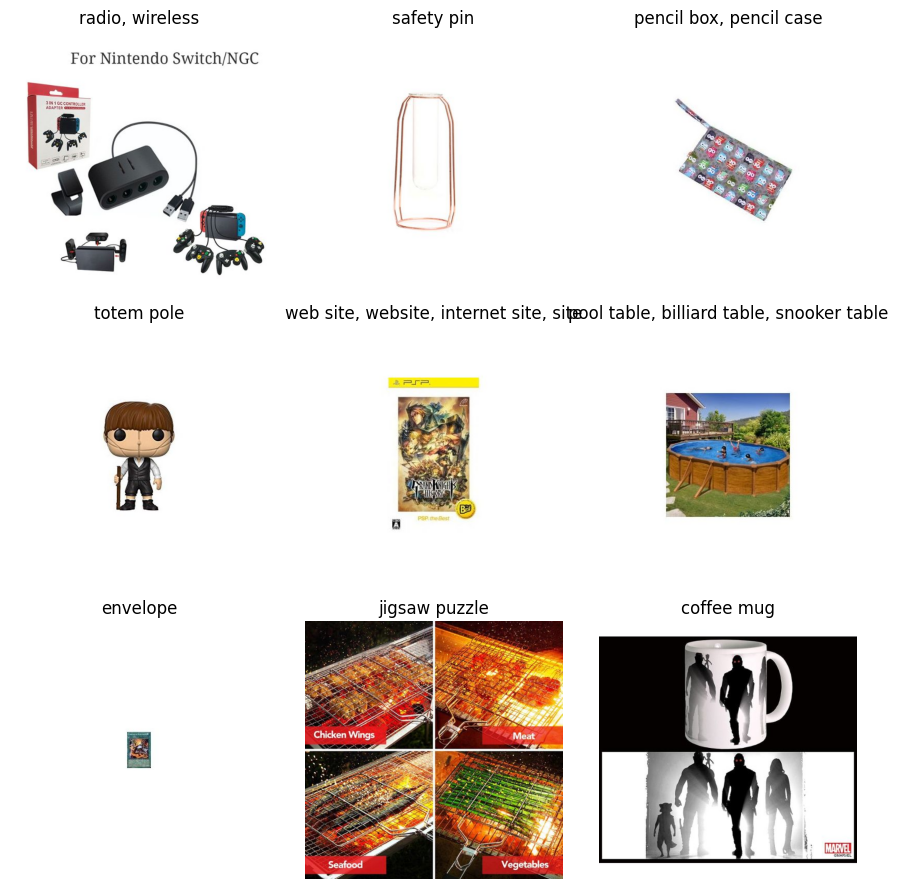

In [83]:
##### Inférence sur les images

resnet_pred_data = []

plt.figure(figsize=(9, 9))

for i, fichier in enumerate(images_to_crop_a_afficher):
    # Récupérer l'imageid et le productid de l'image
    match = re.match(r'image_(\d+)_product_(\d+)\.jpg', fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

        # Ouvrir l'image
        image = Image.open(os.path.join(dossier_images, fichier))

        img_preprocessed = preprocess(image)
        batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)

        # Inférence
        out = resnet101_model(batch_img_tensor)

        # Charger les étiquettes
        with open("/Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/imagenet_classes.txt") as f:
            labels = [line.strip() for line in f.readlines()]

        _, index = torch.max(out, 1)
        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

        # Obtenir les 5 meilleures prédictions
        _, indices = torch.sort(out, descending=True)
        top_predictions = [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

        # Ajouter une sous-figure
        plt.subplot(3, 3, i + 1)  # 6 lignes, 4 colonnes
        plt.imshow(image)
        plt.axis('off')  # Ne pas afficher les axes
        plt.title(f"{labels[index[0]]}")  # Titre avec le nom du fichier

        # Ajouter les résultats à la liste
        resnet_pred_data.append({
            "imageid": image_id,
            "productid": product_id,
            "resnet_pred": labels[index[0]]
        })

# Afficher toutes les images
plt.tight_layout()
plt.show()

# Créer un DataFrame à partir des résultats
resnet_pred_df1 = pd.DataFrame(resnet_pred_data)



In [84]:
# Créer un pipeline de prétraitement
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

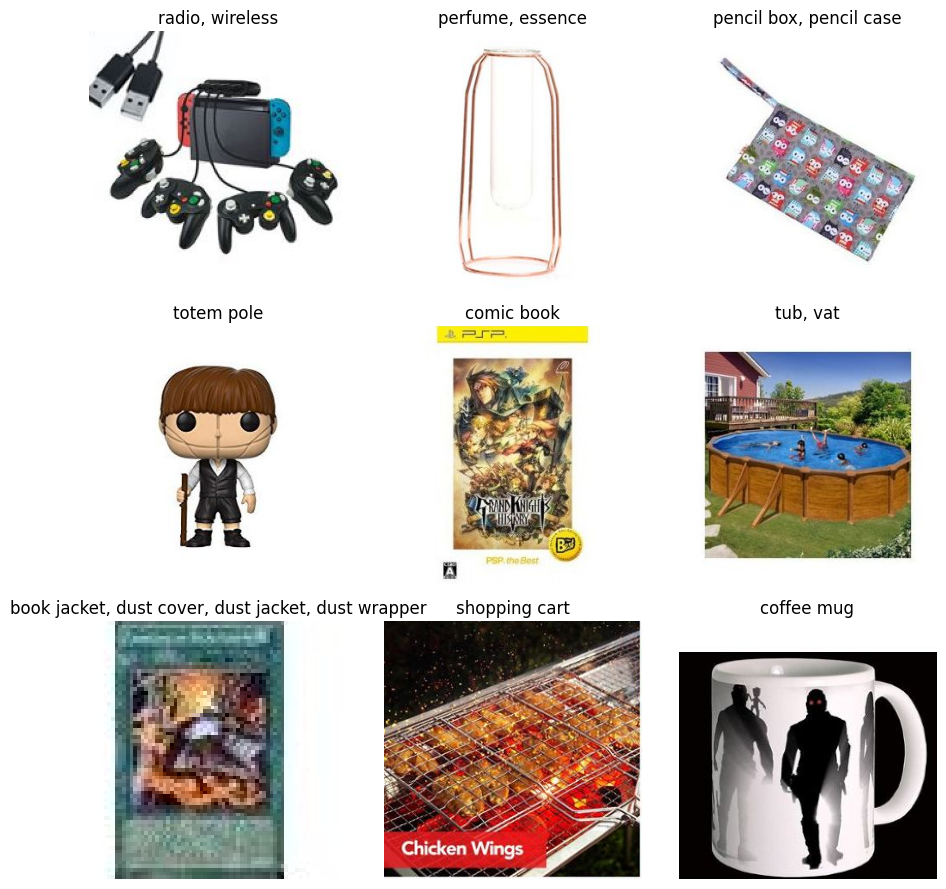

In [85]:
##### Inférence sur les images

resnet_pred_data = []

plt.figure(figsize=(9, 9))

for i, fichier in enumerate(images_to_crop_a_afficher):
    # Récupérer l'imageid et le productid de l'image
    match = re.match(r'image_(\d+)_product_(\d+)\.jpg', fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

        image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image_id == "1313553701":
            cropped_image = image_to_crop(image, 300, 450, 300, 450, seed_img=image_id)
        elif image_id == "1308192555":
            cropped_image = image_to_crop(image, 85, 300, 100, 300, seed_img=image_id)
        elif image_id == "1308179167":
            cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
        elif image_id == "1188833125":
            cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
        elif image_id == "919752936":
            cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
        elif image_id == "1188538863":
            cropped_image = image_to_crop(image, 100, 300, 100, 300, seed_img=image_id)
        elif image_id == "718096430":
            cropped_image = image_to_crop(image, 220, 70, 215, 70, seed_img=image_id)
        elif image_id == "1313687465":
            cropped_image = image_to_crop(image, 0, 250, 0, 250, seed_img=image_id)
        elif image_id == "1120592010":
            cropped_image = image_to_crop(image, 135, 250, 0, 250, seed_img=image_id)
        else:
            cropped_image = image

        resized_image = image_reduce_shape(cropped_image, (256, 256), seed_img=image_id)
        #normalized_image = image_to_normalize(resized_image, mean=0.5, std=0.5, seed_img=image_id)

        img_preprocessed = preprocess(resized_image)
        batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)

        # Inférence
        out = resnet101_model(batch_img_tensor)

        # Charger les étiquettes
        with open("/Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/imagenet_classes.txt") as f:
            labels = [line.strip() for line in f.readlines()]

        _, index = torch.max(out, 1)
        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

        # Obtenir les 5 meilleures prédictions
        _, indices = torch.sort(out, descending=True)
        top_predictions = [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

        # Ajouter une sous-figure
        plt.subplot(3, 3, i + 1)  # 6 lignes, 4 colonnes
        plt.imshow(cropped_image)
        plt.axis('off')  # Ne pas afficher les axes
        plt.title(f"{labels[index[0]]}")  # Titre avec le nom du fichier

        # Ajouter les résultats à la liste
        resnet_pred_data.append({
            "imageid": image_id,
            "productid": product_id,
            "resnet_pred": labels[index[0]]
        })

# Afficher toutes les images
plt.tight_layout()
plt.show()

# Créer un DataFrame à partir des résultats
resnet_pred_df2 = pd.DataFrame(resnet_pred_data)



In [86]:
def auto_crop(image, margin=8):
    # Convertir l'image en niveaux de gris
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Créer un masque pour les pixels non blancs
    _, mask = cv2.threshold(gray_image, 254, 255, cv2.THRESH_BINARY_INV)
    
    # Trouver les coordonnées des pixels non blancs
    coords = np.column_stack(np.where(mask > 0))
    
    if coords.size > 0:
        # Obtenir les coordonnées minimales et maximales
        x_start, y_start = coords.min(axis=0)
        x_end, y_end = coords.max(axis=0)
        
        # Ajuster les coordonnées pour inclure une marge
        x_start = max(x_start - margin, 0)
        y_start = max(y_start - margin, 0)
        x_end = min(x_end + margin, image.shape[1])
        y_end = min(y_end + margin, image.shape[0])
        
        # Découper l'image
        cropped_image = image[y_start:y_end, x_start:x_end]
        return cropped_image
    else:
        return image  # Retourner l'image originale si aucun pixel non blanc n'est trouvé


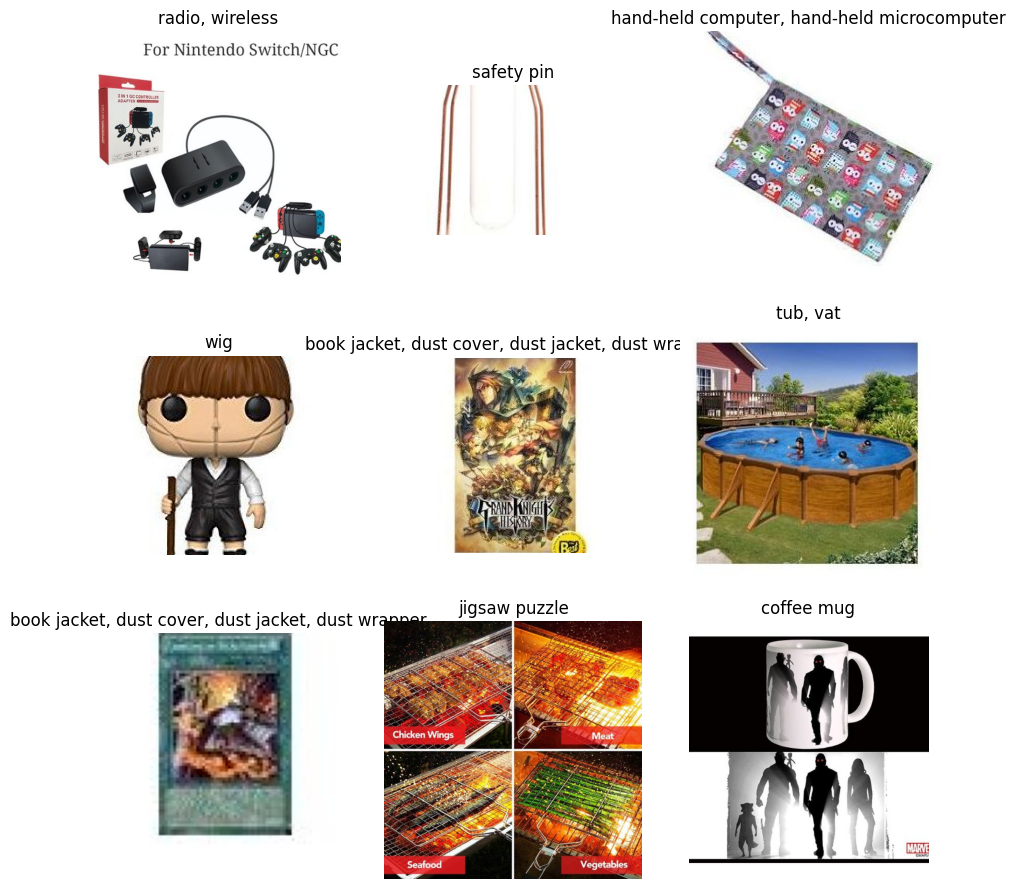

In [87]:
##### Inférence sur les images

resnet_pred_data = []

plt.figure(figsize=(9, 9))

# Utilisation dans votre boucle
for i, fichier in enumerate(images_to_crop_a_afficher):
    # Récupérer l'imageid et le productid de l'image
    match = re.match(r'image_(\d+)_product_(\d+)\.jpg', fichier)
    if match:
        image_id = match.group(1)
        product_id = match.group(2)

        image = cv2.imread(os.path.join(dossier_images, fichier), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Utiliser la fonction auto_crop pour découper l'image
    cropped_image = auto_crop(image)

    resized_image = cropped_image 
    resized_image = image_reduce_shape(cropped_image, (256, 256), seed_img=image_id)
    #normalized_image = image_to_normalize(resized_image, mean=0.5, std=0.5, seed_img=image_id)

    img_preprocessed = preprocess(resized_image)
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)

    # Inférence
    out = resnet101_model(batch_img_tensor)

    # Charger les étiquettes
    with open("/Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/imagenet_classes.txt") as f:
        labels = [line.strip() for line in f.readlines()]

    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

    # Obtenir les 5 meilleures prédictions
    _, indices = torch.sort(out, descending=True)
    top_predictions = [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

    # Ajouter une sous-figure
    plt.subplot(3, 3, i + 1)  # 6 lignes, 4 colonnes
    plt.imshow(cropped_image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"{labels[index[0]]}")  # Titre avec le nom du fichier

    # Ajouter les résultats à la liste
    resnet_pred_data.append({
        "imageid": image_id,
        "productid": product_id,
        "resnet_pred": labels[index[0]]
    })

# Afficher toutes les images
plt.tight_layout()
plt.show()

# Créer un DataFrame à partir des résultats
resnet_pred_df3 = pd.DataFrame(resnet_pred_data)
